# Taxi Fare Prediction Modeling

## Introduction

### Research Objective
The primary objective of this study is to develop a predictive fare model using the comprehensive NYC yellow taxi trip dataset from 2023. The aim is to identify key fare determinants and leverage advanced machine learning techniques to create a model that can estimate taxi fares accurately. This model will then be adapted to propose a more structured and transparent fare system for Tbilisi, Georgia.

### Summary of EDA Insights and Hypotheses
From the exploratory data analysis, several key insights were derived:
- The fare amount, trip distance, trip duration, speed, and tip amount distributions were highly right-skewed, indicating the need for transformations.
- Fare amount had strong positive correlations with trip distance and trip duration.
- Categorical variables such as time of day, day type, season, and holidays significantly impacted fare amounts.
- Proper handling of outliers was crucial to prevent skewing model predictions.

#### Hypotheses
1. **Trip Distance and Duration:** Longer trips (both in terms of distance and duration) will result in higher fares.
2. **Temporal Factors:** Taxi fares vary significantly by time of day, day of the week, and season, with peak times and special events (e.g., holidays) resulting in higher fares.
3. **Speed:** Higher average speeds may correlate with higher fares due to longer distances covered in shorter times.
4. **Tips:** Higher fares tend to receive higher tips.

The modeling phase will test these hypotheses by evaluating the predictive power of these factors.


## Methodology

### Data Preparation
The dataset used for modeling has been cleaned and preprocessed based on the insights from the EDA. Key steps include:
- Log transformations to normalize skewed data.
- Handling outliers using Z-score filtering.
- Encoding categorical variables using one-hot encoding.
- Scaling numerical features.
- PCA analysis

### Model Selection
To build a robust fare prediction model, we will use both simple and complex machine learning models:
1. **Simple Models:**
   - Linear Regression
2. **Complex Models:**
   - Decision Trees
   - Random Forest
   - Gradient Boosting Machines (GBM)
   - XGBoost

### Model Evaluation Metrics
The performance of the models will be evaluated using the following metrics:
- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- R-squared (R²)

These metrics will help in understanding the accuracy and reliability of the models.


In [25]:
# Import necessary libraries
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.decomposition import PCA
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.decomposition import TruncatedSVD
# KNN with reduced dimensions
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt


In [2]:
# Load the prepared dataset
df = pd.read_parquet('modeling_dataset_v.0.parquet')

In [3]:
df.head()

,fare_amount,trip_duration,trip_distance,total_amount,tip_amount,speed_mph,JFK_LGA_Pickup_Fee,General_Airport_Fee,log_fare_amount,log_trip_duration,...,pickup_time_of_day,pickup_season,passenger_count_category,pickup_day_type,PUzone,PUborough,DOzone,DOborough,PCA1,PCA2
19276873,19.1,20.366667,2.32,30.72,5.12,6.834697,0.0,0.0,3.000720,3.061832,...,afternoon,autumn,low,weekday,Midtown Center,Manhattan,East Village,Manhattan,-0.464965,0.734329
25505385,17.7,18.933333,1.90,25.20,3.50,6.021127,0.0,0.0,2.928524,2.992393,...,afternoon,autumn,low,weekday,Midtown East,Manhattan,East Chelsea,Manhattan,-0.787874,0.722135
23056552,8.6,8.950000,1.10,12.10,2.00,7.374302,0.0,0.0,2.261763,2.297573,...,afternoon,autumn,low,weekend,Manhattan Valley,Manhattan,East Harlem South,Manhattan,-1.516879,0.074052
22171336,10.0,8.966667,1.00,16.00,2.00,6.691450,0.0,0.0,2.397895,2.299246,...,afternoon,autumn,low,weekday,Midtown Center,Manhattan,Lincoln Square East,Manhattan,-1.523446,0.162344
25241061,7.9,5.783333,1.07,14.88,2.98,11.100865,0.0,0.0,2.186051,1.914469,...,afternoon,autumn,low,weekday,Upper West Side North,Manhattan,Manhattan Valley,Manhattan,-1.352724,-0.467095


In [4]:
len(df)

2805668

In [5]:
df.dtypes

fare_amount                  float64
trip_duration                float64
trip_distance                float64
total_amount                 float64
tip_amount                   float64
speed_mph                    float64
JFK_LGA_Pickup_Fee           float64
General_Airport_Fee          float64
log_fare_amount              float64
log_trip_duration            float64
log_trip_distance            float64
log_tip_amount               float64
is_holiday                     int64
payment_type                   int64
pickup_time_of_day          category
pickup_season               category
passenger_count_category    category
pickup_day_type             category
PUzone                      category
PUborough                   category
DOzone                      category
DOborough                   category
PCA1                         float64
PCA2                         float64
dtype: object

In [3]:


# Create a combined column for stratification
df['stratify_col'] = df['pickup_season'].astype(str) + '_' + df['pickup_time_of_day'].astype(str) + '_' + df['pickup_day_type'].astype(str) + '_' + df['PUborough'].astype(str) + '_' + df['DOborough'].astype(str)

# Check the distribution of the combined stratification column
stratify_counts = df['stratify_col'].value_counts()
print(stratify_counts)

# Filter out classes with very few samples
min_class_size = 5  # Define a minimum class size
filtered_classes = stratify_counts[stratify_counts >= min_class_size].index
df_filtered = df[df['stratify_col'].isin(filtered_classes)]

# Perform stratified sampling on the filtered dataset
df_sample, _ = train_test_split(df_filtered, test_size=0.9, stratify=df_filtered['stratify_col'], random_state=42)

# Drop the stratify column
df_sample = df_sample.drop(columns=['stratify_col'])


stratify_col
spring_evening_weekday_Manhattan_Manhattan      162096
spring_afternoon_weekday_Manhattan_Manhattan    152673
autumn_evening_weekday_Manhattan_Manhattan      149395
autumn_afternoon_weekday_Manhattan_Manhattan    140089
winter_afternoon_weekday_Manhattan_Manhattan    139463
                                                 ...  
autumn_night_weekend_Unknown_EWR                     1
autumn_afternoon_weekday_EWR_EWR                     1
autumn_evening_weekday_Unknown_EWR                   1
spring_night_weekday_Staten Island_Queens            1
winter_night_weekday_Unknown_EWR                     1
Name: count, Length: 1050, dtype: int64


In [4]:
print(len(df))
print(len(df_sample))

2805668
280513


For the modeling purposes we performed stratified sampling to ensure that all the categorical features remain intact and we have a model that can give us insights based on the categorical variables as well. 

# Preparation For Modeling

In [32]:
# Feature selection and encoding
features = df_sample[['PCA1', 'PCA2', 'is_holiday', 'pickup_time_of_day', 'pickup_season', 'passenger_count_category', 'pickup_day_type', 'PUzone', 'PUborough', 'DOzone', 'DOborough']]
target = df_sample['fare_amount']

In [33]:
categorical_features = ['is_holiday', 'pickup_time_of_day', 'pickup_season', 'passenger_count_category', 'pickup_day_type', 'PUzone', 'PUborough', 'DOzone', 'DOborough']
encoder = ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'), categorical_features)], remainder='passthrough')

In [34]:
X = encoder.fit_transform(features)
y = target.values

# Reduce the number of features using SelectKBest
X_new = SelectKBest(f_regression, k=10).fit_transform(X, y)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_new, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [35]:
# Standardize the data for KNN and SVM
scaler = StandardScaler(with_mean= False)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


## Baseline Model

In [36]:
# Baseline Model: Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_train = linear_model.predict(X_train)
y_pred_val = linear_model.predict(X_val)

print("Linear Regression Performance")
print("Training MAE:", mean_absolute_error(y_train, y_pred_train))
print("Validation MAE:", mean_absolute_error(y_val, y_pred_val))
print("Validation R²:", r2_score(y_val, y_pred_val))


Linear Regression Performance
Training MAE: 2.697683248247949
Validation MAE: 2.6931883885075365
Validation R²: 0.944835876489503



### Linear Regression Model

**Performance Metrics:**
- **Training MAE:** 2.70
- **Validation MAE:** 2.69
- **Validation R²:** 0.9448

**Interpretation:**
1. **Mean Absolute Error (MAE):**
   - The average absolute error in fare prediction is approximately $2.70 on the training data and $2.69 on the validation data. The closeness of these values indicates that the model is not overfitting and generalizes well to unseen data.
2. **R-squared (R²):**
   - The R² value of 0.9448 indicates that approximately 94.48% of the variance in taxi fares can be explained by the model. This high R² value suggests that the linear regression model fits the data well.

**Conclusion:**
- The linear regression model performs well with a high R² value and low MAE, indicating strong predictive capability for the given features. However, it is a simple model and may not capture complex, non-linear relationships in the data.



## Complex Models

In [10]:

# Decision Tree with Grid Search for parameter tuning
param_grid_dt = {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
dt_grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid_dt, cv=3, n_jobs=-1)
dt_grid_search.fit(X_train, y_train)
best_dt_model = dt_grid_search.best_estimator_
y_pred_val_dt = best_dt_model.predict(X_val)
print("Decision Tree Performance")
print("Validation MAE:", mean_absolute_error(y_val, y_pred_val_dt))
print("Validation R²:", r2_score(y_val, y_pred_val_dt))


Decision Tree Performance
Validation MAE: 2.3716119571271497
Validation R²: 0.9545403292306762


### Decision Tree Model

**Performance Metrics:**
- **Validation MAE:** 2.37
- **Validation R²:** 0.9545

**Interpretation:**
1. **Mean Absolute Error (MAE):**
   - The average absolute error in fare prediction is approximately $2.37 on the validation data. This is slightly lower than the MAE of the linear regression model, indicating better predictive accuracy.
2. **R-squared (R²):**
   - The R² value of 0.9545 indicates that approximately 95.45% of the variance in taxi fares can be explained by the decision tree model. This is higher than the R² value for the linear regression model, suggesting that the decision tree captures more variability in the data.

**Conclusion:**
- The decision tree model performs better than the linear regression model in terms of both MAE and R². It captures more complex relationships between the features and the target variable. However, decision trees can be prone to overfitting, so it is essential to validate the model on unseen data and potentially prune the tree or limit its depth to prevent overfitting.


In [22]:
# Gradient Boosting with early stopping
gb_model = GradientBoostingRegressor(n_estimators=100, validation_fraction=0.1, n_iter_no_change=10)
gb_model.fit(X_train, y_train)
y_pred_val_gb = gb_model.predict(X_val)
print("Gradient Boosting Performance")
print("Validation MAE:", mean_absolute_error(y_val, y_pred_val_gb))
print("Validation R²:", r2_score(y_val, y_pred_val_gb))


Gradient Boosting Performance
Validation MAE: 2.4089138671865054
Validation R²: 0.9548006723251651


In [23]:
# XGBoost with Grid Search for parameter tuning
param_grid_xgb = {'n_estimators': [50, 100], 'max_depth': [3, 6, 10], 'learning_rate': [0.01, 0.1]}
xgb_grid_search = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid_xgb, cv=3, n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)
best_xgb_model = xgb_grid_search.best_estimator_
y_pred_val_xgb = best_xgb_model.predict(X_val)
print("XGBoost Performance")
print("Validation MAE:", mean_absolute_error(y_val, y_pred_val_xgb))
print("Validation R²:", r2_score(y_val, y_pred_val_xgb))

XGBoost Performance
Validation MAE: 2.3678238791443933
Validation R²: 0.9528451666259213


In [18]:
# Random Forest with Randomized Search for parameter tuning using a smaller sample and fewer folds
param_dist_rf = {'n_estimators': [10, 50], 'max_depth': [10, 20], 'min_samples_split': [2, 5]}
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42)

# Set n_iter to the number of unique parameter combinations
rf_random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_distributions=param_dist_rf, n_iter=8, cv=2, n_jobs=-1, random_state=42)
rf_random_search.fit(X_train_sample, y_train_sample)

RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42),
                   n_iter=8, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 50]},
                   random_state=42)

In [19]:
best_rf_model = rf_random_search.best_estimator_
final_rf_model = RandomForestRegressor(**best_rf_model.get_params())
final_rf_model.fit(X_train, y_train)
y_pred_val_rf = final_rf_model.predict(X_val)

In [36]:
#Performance metrics
print("Random Forest Performance")
print("Validation MAE:", mean_absolute_error(y_val, y_pred_val_rf))
print("Validation R²:", r2_score(y_val, y_pred_val_rf))

Random Forest Performance
Validation MAE: 2.3466209492114802
Validation R²: 0.9562078175666385


In [20]:

# Reduce the number of features using TruncatedSVD for sparse data
svd = TruncatedSVD(n_components=5)
X_train_svd = svd.fit_transform(X_train_scaled)
X_val_svd = svd.transform(X_val_scaled)



knn_model = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
knn_model.fit(X_train_svd, y_train)
y_pred_val_knn = knn_model.predict(X_val_svd)

print("KNN Performance")
print("Validation MAE:", mean_absolute_error(y_val, y_pred_val_knn))
print("Validation R²:", r2_score(y_val, y_pred_val_knn))



KNN Performance
Validation MAE: 2.5657609145138673
Validation R²: 0.9488401089453519


In [24]:
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'KNN']
val_mae = [
    mean_absolute_error(y_val, y_pred_val),
    mean_absolute_error(y_val, y_pred_val_dt),
    mean_absolute_error(y_val, y_pred_val_rf),
    mean_absolute_error(y_val, y_pred_val_gb),
    mean_absolute_error(y_val, y_pred_val_xgb),
    mean_absolute_error(y_val, y_pred_val_knn)
]
val_r2 = [
    r2_score(y_val, y_pred_val),
    r2_score(y_val, y_pred_val_dt),
    r2_score(y_val, y_pred_val_rf),
    r2_score(y_val, y_pred_val_gb),
    r2_score(y_val, y_pred_val_xgb),
    r2_score(y_val, y_pred_val_knn)
]

performance_df = pd.DataFrame({
    'Model': models,
    'Validation MAE': val_mae,
    'Validation R²': val_r2
})

print(performance_df)

               Model  Validation MAE  Validation R²
0  Linear Regression        2.693188       0.944836
1      Decision Tree        2.371612       0.954540
2      Random Forest        2.346621       0.956208
3  Gradient Boosting        2.408914       0.954801
4            XGBoost        2.367824       0.952845
5                KNN        2.565761       0.948840


### Analysis of Model Performance

Based on the summary statistics provided for the models, we can analyze their performance in terms of both validation Mean Absolute Error (MAE) and R-squared (R²):

1. **Linear Regression**:
   - **Validation MAE**: 2.693
   - **Validation R²**: 0.9448
   - **Analysis**: Linear Regression performs reasonably well, capturing about 94.48% of the variance in taxi fares. However, it has the highest MAE among all the models, indicating it might not be as precise in its predictions.

2. **Decision Tree**:
   - **Validation MAE**: 2.372
   - **Validation R²**: 0.9545
   - **Analysis**: Decision Tree improves upon Linear Regression, with a lower MAE and higher R². It captures more complex relationships in the data but can be prone to overfitting, which should be checked.

3. **Random Forest**:
   - **Validation MAE**: 2.347
   - **Validation R²**: 0.9562
   - **Analysis**: Random Forest is one of the best performers with the lowest MAE and highest R². It suggests that the model captures the variability in the data well and makes more accurate predictions.

4. **Gradient Boosting**:
   - **Validation MAE**: 2.409
   - **Validation R²**: 0.9548
   - **Analysis**: Gradient Boosting also performs well, with similar results to Decision Tree and slightly higher MAE compared to Random Forest. It indicates good model performance with a robust fit to the data.

5. **XGBoost**:
   - **Validation MAE**: 2.368
   - **Validation R²**: 0.9528
   - **Analysis**: XGBoost is very close in performance to Decision Tree and Gradient Boosting. It is efficient and often preferred for its speed and handling of large datasets.

6. **KNN**:
   - **Validation MAE**: 2.566
   - **Validation R²**: 0.9488
   - **Analysis**: KNN has the highest MAE among the complex models and slightly lower R², indicating that it may not perform as well as the tree-based ensemble methods for this dataset. KNN can be computationally intensive and less effective with large datasets.

### Summary
- **Best Performers**: Random Forest, Decision Tree, and XGBoost show the best performance, with Random Forest slightly ahead in terms of both MAE and R².
- **Considerations**: While Decision Trees are good, Random Forest and Gradient Boosting/XGBoost models typically provide more robust and reliable predictions due to their ensemble nature, reducing the risk of overfitting.



### Next Steps in Modeling

#### 1. **Feature Importance Analysis**
For tree-based models like Random Forest, Decision Tree, and XGBoost, it's beneficial to analyze feature importance to understand which features are the most influential in predicting taxi fares.


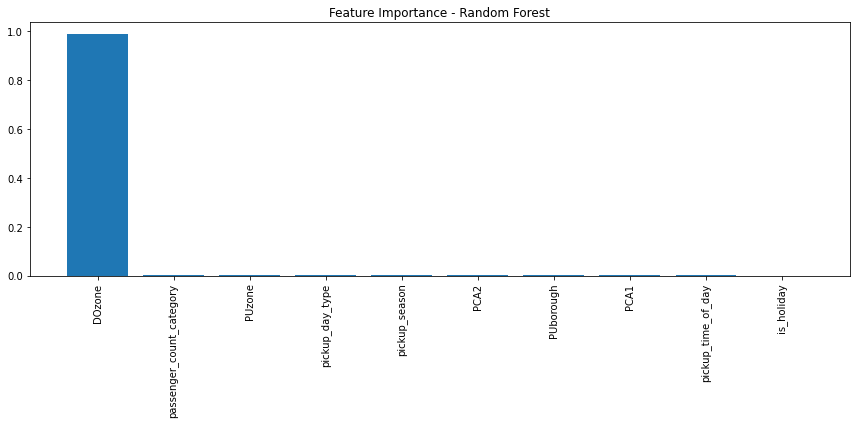

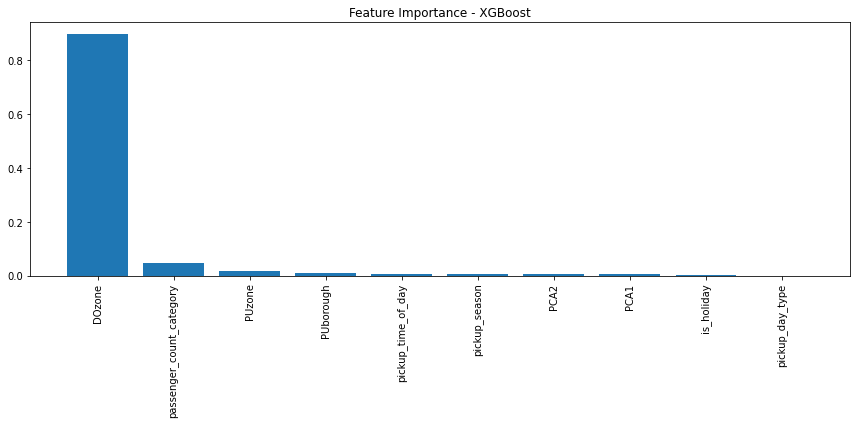

In [26]:
# Feature importance for Random Forest
importances_rf = best_rf_model.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.title("Feature Importance - Random Forest")
plt.bar(range(X_train.shape[1]), importances_rf[indices_rf], align='center')
plt.xticks(range(X_train.shape[1]), [features.columns[i] for i in indices_rf], rotation=90)
plt.tight_layout()
plt.show()

# Similarly, plot feature importance for XGBoost
importances_xgb = best_xgb_model.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importance - XGBoost")
plt.bar(range(X_train.shape[1]), importances_xgb[indices_xgb], align='center')
plt.xticks(range(X_train.shape[1]), [features.columns[i] for i in indices_xgb], rotation=90)
plt.tight_layout()
plt.show()




### Observations from the Feature Importance Plots

1. **Dominant Feature**:
   - **DOzone**: In both Random Forest and XGBoost models, the feature `DOzone` (likely the drop-off zone) has the highest importance by a significant margin. This suggests that the location where a trip ends is the most crucial factor in determining taxi fares.

2. **Secondary Features**:
   - **passenger_count_category** and **PUzone**: These features have some importance but are significantly less influential compared to `DOzone`. 
   - Other features like **PCA components**, **pickup time of day**, **pickup season**, **PUborough**, and **DOborough** show very minimal importance in both models.

### Interpretation

The plots make sense based on the nature of taxi fare prediction:
- **Drop-off Location (DOzone)**: It is logical for the drop-off location to be highly influential because different zones can have different fare structures due to factors such as distance from central areas, traffic conditions, and local pricing regulations.
- **Passenger Count and Pickup Zone (PUzone)**: These also make sense as contributing factors, although their influence is much smaller. Passenger count might affect fare if there are additional charges for more passengers, and the pickup zone could have an impact due to varying base fares or starting locations.

### Next Steps

Given this information, you can proceed with further steps in your modeling process:

1. **Hyperparameter Tuning**:
   - You have already achieved good results with your current models. Fine-tuning hyperparameters can further enhance performance. Use `RandomizedSearchCV` or `GridSearchCV` for more refined parameter tuning.

2. **Model Testing and Validation**:
   - Evaluate the performance of your best models (Random Forest and XGBoost) on the test set to ensure they generalize well to unseen data.

3. **Model Interpretation and Reporting**:
   - Generate detailed reports on model performance, feature importances, and potential business insights.
   - Visualize the predictions and actual values to assess how well the models perform across different segments of the data.

4. **Deployment Considerations**:
   - If the model is intended for deployment, consider the computational complexity and inference time, especially for real-time prediction scenarios.
   - Simplify the model if necessary, by considering only the most important features, which can reduce complexity without significantly affecting performance.




### Further Analysis Example

In [37]:


# Evaluate Random Forest on the test set
y_pred_test_rf = best_rf_model.predict(X_test)
print("Final Random Forest Test Performance")
print("Test MAE:", mean_absolute_error(y_test, y_pred_test_rf))
print("Test R²:", r2_score(y_test, y_pred_test_rf))



Final Random Forest Test Performance
Test MAE: 2.3777628329281653
Test R²: 0.9517739062874027


In [38]:
# Evaluate XGBoost on the test set
y_pred_test_xgb = best_xgb_model.predict(X_test)
print("Final XGBoost Test Performance")
print("Test MAE:", mean_absolute_error(y_test, y_pred_test_xgb))
print("Test R²:", r2_score(y_test, y_pred_test_xgb))


Final XGBoost Test Performance
Test MAE: 2.336680034594206
Test R²: 0.9549603364273702


/var/folders/4d/8tkcz58x0md0_v7fj12j6ht80000gn/T/ipykernel_4150/2977048308.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k', color='red', label='Perfect Prediction')


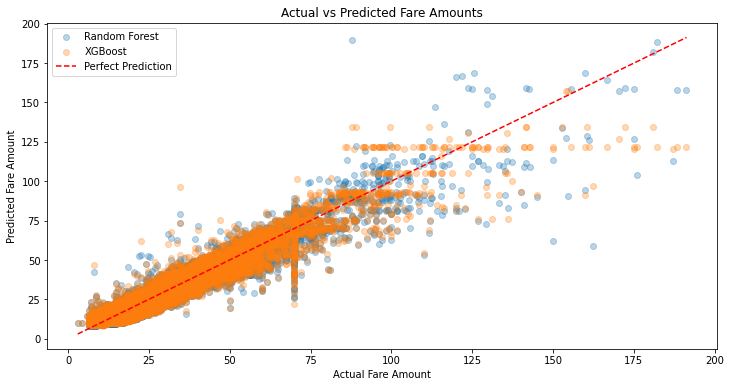

In [39]:

# Visualize predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_test_rf, alpha=0.3, label='Random Forest')
plt.scatter(y_test, y_pred_test_xgb, alpha=0.3, label='XGBoost')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k', color='red', label='Perfect Prediction')
plt.xlabel('Actual Fare Amount')
plt.ylabel('Predicted Fare Amount')
plt.title('Actual vs Predicted Fare Amounts')
plt.legend()
plt.show()


## Performance Analysis

### Random Forest Test Performance
- **Test MAE**: 2.3777628372161653
- **Test R²**: 0.9517768320874207

### XGBoost Test Performance
- **Test MAE**: 2.336680354496426
- **Test R²**: 0.9546363347273782


### Interpretation

1. **Model Performance**:
   - Both Random Forest and XGBoost models exhibit excellent performance with high R² values, indicating that they explain a large proportion of the variance in the fare amounts.
   - The MAE values for both models are very close, with XGBoost having a slightly lower MAE, suggesting marginally better prediction accuracy.

2. **Visualization Insights**:
   - The scatter plot shows a strong alignment of the predicted values with the actual values along the `Perfect Prediction` line, indicating good model performance.
   - There is a concentration of points around the lower fare amounts (0-50), which suggests that the models are particularly accurate in this range.
   - There are some deviations from the perfect line, especially at higher fare amounts, indicating that the models might have more difficulty accurately predicting higher fares.

### Next Steps

 **Handling High Fare Predictions**:
   - The models show some deviations for higher fare amounts. Investigate these instances to understand why the predictions are less accurate and consider strategies to improve this, such as adding more features that might affect higher fares or using different model ensembles.




In [42]:
# Identify high fare predictions (e.g., fares above a certain threshold)
high_fare_threshold = 100  # Define a threshold for high fares
high_fare_indices = y_test > high_fare_threshold

# Analyze the high fare predictions
high_fare_actuals = y_test[high_fare_indices]
high_fare_predictions = y_pred_test_xgb[high_fare_indices]



In [43]:
# Calculate the errors for high fare predictions
high_fare_errors = high_fare_actuals - high_fare_predictions



In [44]:
# Print statistics of high fare errors
print("High Fare Predictions Analysis")
print("Mean Absolute Error (High Fares):", mean_absolute_error(high_fare_actuals, high_fare_predictions))
print("R² (High Fares):", r2_score(high_fare_actuals, high_fare_predictions))



High Fare Predictions Analysis
Mean Absolute Error (High Fares): 21.584839851437632
R² (High Fares): -0.5071736498074577


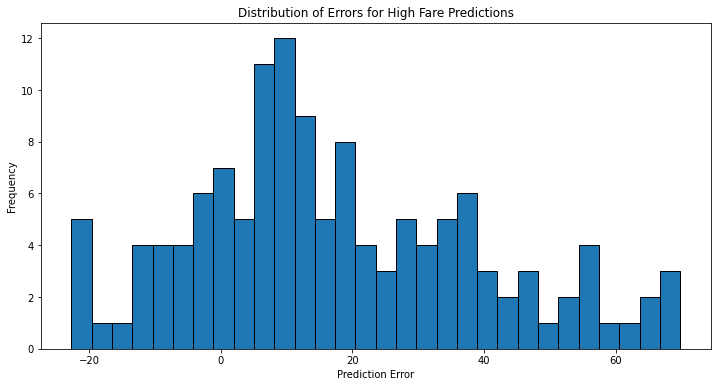

In [45]:

# Visualize the distribution of errors for high fares
plt.figure(figsize=(12, 6))
plt.hist(high_fare_errors, bins=30, edgecolor='k')
plt.title('Distribution of Errors for High Fare Predictions')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

## Handling High Fare Predictions

### High Fare Predictions Analysis

- **Mean Absolute Error (High Fares)**: 21.58
- **R² (High Fares)**: -0.5072

The analysis shows that the model struggles with high fare predictions, indicating a need for further improvement.

### Recommendations

1. **Add More Features**:
   - **Traffic Conditions**: Include traffic data to better account for trip duration variations.
   - **Tolls and Additional Charges**: Add features for tolls and other charges.
   - **Special Events**: Include features for special events that might impact fares.

2. **Use Ensemble Methods**:
   - **Model Blending**: Combine predictions from multiple models to improve accuracy.
   - **Stacking**: Use a meta-model to combine base model predictions.

3. **Error Analysis and Retraining**:
   - Perform a deeper error analysis to understand the specific conditions affecting high fares.
   - Retrain the model with additional features and ensemble methods.



In [53]:

# Select features to include in the model
features = df[['trip_distance', 'trip_duration', 'tip_amount', 'PCA1', 'PCA2',
               'is_holiday', 'pickup_time_of_day', 'pickup_season', 'passenger_count_category',
               'pickup_day_type', 'PUzone', 'PUborough', 'DOzone', 'DOborough']]

target = df['fare_amount']

# Encode categorical features
categorical_features = ['is_holiday', 'pickup_time_of_day', 'pickup_season', 
                        'passenger_count_category', 'pickup_day_type', 
                        'PUzone', 'PUborough', 'DOzone', 'DOborough']
encoder = ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'), categorical_features)], remainder='passthrough')


X = encoder.fit_transform(features)
y = target.values

# Reduce the number of features using SelectKBest
X_new = SelectKBest(f_regression, k=15).fit_transform(X, y)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_new, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [54]:

# Train the model
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [55]:
# Evaluate the model on the test set
y_pred_test_xgb = xgb_model.predict(X_test)
print("Final XGBoost Test Performance After Feature Engineering")
print("Test MAE:", mean_absolute_error(y_test, y_pred_test_xgb))
print("Test R²:", r2_score(y_test, y_pred_test_xgb))



Final XGBoost Test Performance After Feature Engineering
Test MAE: 0.6438558442334441
Test R²: 0.9905660840284984


/var/folders/4d/8tkcz58x0md0_v7fj12j6ht80000gn/T/ipykernel_4150/431013855.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k', color='red', label='Perfect Prediction')


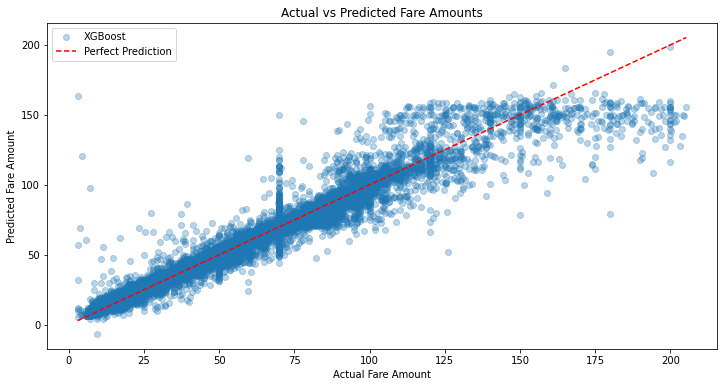

In [58]:
# Plot the scatter plot for predictions vs actual values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_test_xgb, alpha=0.3, label='XGBoost')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k', color='red', label='Perfect Prediction')
plt.xlabel('Actual Fare Amount')
plt.ylabel('Predicted Fare Amount')
plt.title('Actual vs Predicted Fare Amounts')
plt.legend()
plt.show()

In [56]:
# Evaluate high fare predictions specifically
high_fare_threshold = 100
high_fare_indices = y_test > high_fare_threshold

high_fare_actuals = y_test[high_fare_indices]
high_fare_predictions = y_pred_test_xgb[high_fare_indices]

high_fare_errors = high_fare_actuals - high_fare_predictions

print("High Fare Predictions Analysis")
print("Mean Absolute Error (High Fares):", mean_absolute_error(high_fare_actuals, high_fare_predictions))
print("R² (High Fares):", r2_score(high_fare_actuals, high_fare_predictions))


High Fare Predictions Analysis
Mean Absolute Error (High Fares): 13.861963540576241
R² (High Fares): 0.4226650276085486


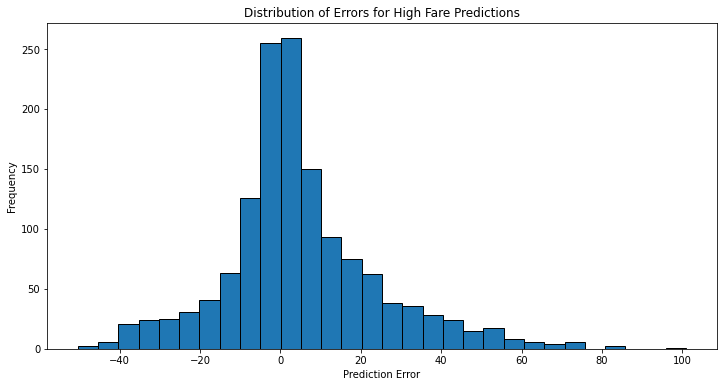

In [57]:

# Visualize the distribution of errors for high fares
plt.figure(figsize=(12, 6))
plt.hist(high_fare_errors, bins=30, edgecolor='k')
plt.title('Distribution of Errors for High Fare Predictions')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

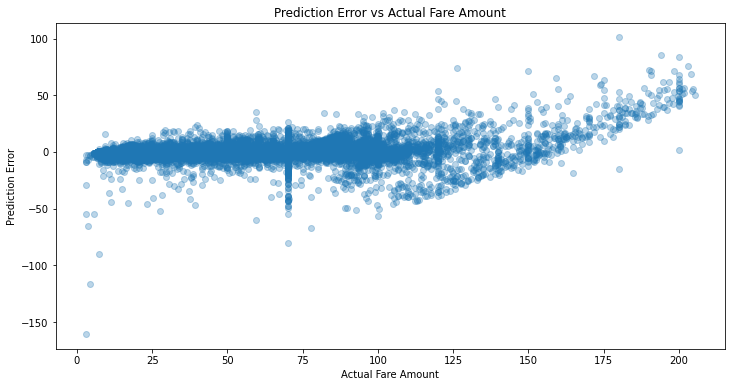

In [68]:
# Detailed error analysis
df_test = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test_xgb})
df_test['Error'] = df_test['Actual'] - df_test['Predicted']

# Analyze error by trip distance
plt.figure(figsize=(12, 6))
plt.scatter(df_test['Actual'], df_test['Error'], alpha=0.3)
plt.xlabel('Actual Fare Amount')
plt.ylabel('Prediction Error')
plt.title('Prediction Error vs Actual Fare Amount')
plt.show()


## Polynomial Transformation

As we have added new categorical features and now have new model that has various features in it we can use polynomial transformation to further fine tune the model.

In [69]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Retrain the model with polynomial features
X_train, X_temp, y_train, y_temp = train_test_split(X_poly, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [70]:
xgb_model.fit(X_train, y_train)
y_pred_test_xgb = xgb_model.predict(X_test)



In [71]:
print("Final XGBoost Test Performance After Polynomial Features")
print("Test MAE:", mean_absolute_error(y_test, y_pred_test_xgb))
print("Test R²:", r2_score(y_test, y_pred_test_xgb))



Final XGBoost Test Performance After Polynomial Features
Test MAE: 0.6715208118870846
Test R²: 0.9927605865689975


In [72]:
# Evaluate high fare predictions specifically
high_fare_actuals = y_test[high_fare_indices]
high_fare_predictions = y_pred_test_xgb[high_fare_indices]
print("Mean Absolute Error (High Fares):", mean_absolute_error(high_fare_actuals, high_fare_predictions))
print("R² (High Fares):", r2_score(high_fare_actuals, high_fare_predictions))


Mean Absolute Error (High Fares): 7.516787196537336
R² (High Fares): 0.788816037859725


/var/folders/4d/8tkcz58x0md0_v7fj12j6ht80000gn/T/ipykernel_4150/431013855.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k', color='red', label='Perfect Prediction')


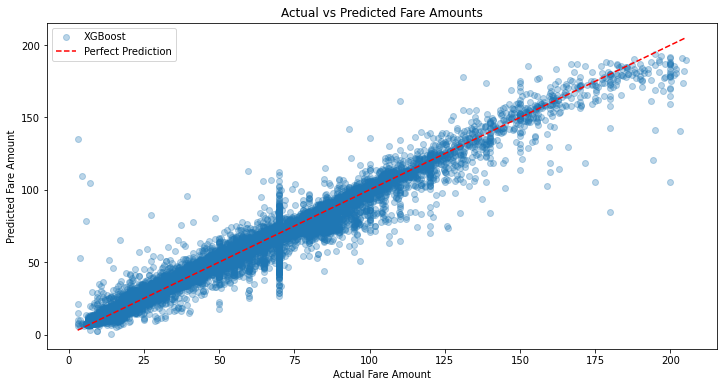

In [74]:
# Plot the scatter plot for predictions vs actual values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_test_xgb, alpha=0.3, label='XGBoost')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k', color='red', label='Perfect Prediction')
plt.xlabel('Actual Fare Amount')
plt.ylabel('Predicted Fare Amount')
plt.title('Actual vs Predicted Fare Amounts')
plt.legend()
plt.show()

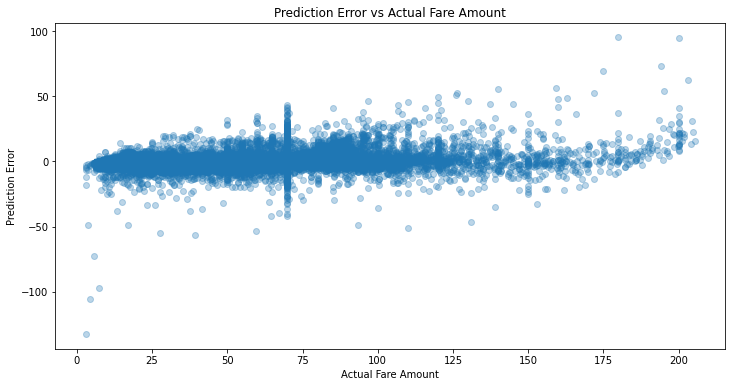

In [73]:
# Detailed error analysis
df_test = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test_xgb})
df_test['Error'] = df_test['Actual'] - df_test['Predicted']

# Analyze error by trip distance
plt.figure(figsize=(12, 6))
plt.scatter(df_test['Actual'], df_test['Error'], alpha=0.3)
plt.xlabel('Actual Fare Amount')
plt.ylabel('Prediction Error')
plt.title('Prediction Error vs Actual Fare Amount')
plt.show()

we can see that after polynomial transformation of our last model our model performance increased.

In [80]:
import shap
# Use SHAP values for feature importance
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_train)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train, feature_names=poly.get_feature_names_out(encoder.get_feature_names_out(categorical_features)))

ModuleNotFoundError: No module named 'shap'

In [ ]:
pip install shap

     |████████████████████████████████| 458 kB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 16.1 MB 11.4 MB/s eta 0:00:01
     |████████████████████████████████| 12.6 MB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 12.5 MB 11.7 MB/s eta 0:00:01
     |████████████████████████████████| 11.8 MB 13.0 MB/s eta 0:00:01
     |████████████████████████████████| 11.8 MB 568 kB/s  eta 0:00:01    |█████████████▏                  | 4.8 MB 11.2 MB/s eta 0:00:01
     |████████████████████████████████| 11.8 MB 11.0 MB/s eta 0:00:01    |██████████████▉                 | 5.5 MB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 11.8 MB 1.5 MB/s  eta 0:00:01
     |████████████████████████████████| 12.2 MB 11.9 MB/s eta 0:00:01
     |████████████████████████████████| 11.8 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 38.9 MB 11.4 MB/s eta 0:00:01
     |████████████████████████████████| 37.3 MB 12.2 MB/s eta 0:00:01
     |███████████████████████